# Analysis of Seurat and LIGER alignment

## Setup

In [42]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('colorblind')
palette = sns.color_palette('colorblind')

import os
import pandas as pd
import numpy as np

WORKDIR = "/fh/fast/gottardo_r/data_transfer/spatial-datasets/"
os.chdir(WORKDIR)

## Load data

In [10]:
meta = pd.read_csv('results/alignment/seurat_thrane1.2-tirosh_metadata.csv', index_col=0)
embed = pd.read_csv('results/alignment/seurat_thrane1.2-tirosh_umap.csv', index_col=0)

seurat = meta.join(embed)

In [39]:
samples = ["1.2_ST", "Tirosh"]
cell_types = ["T-cell", "B-cell", "Macrophage", "Endothelial", "CAF", "NK", "Melanoma", "Unclassified"]
index = pd.MultiIndex.from_product(iterables=[range(1, 4), cell_types], names=['spatial.cluster', 'cell_type_inferred'])

In [93]:
ST = seurat.loc[seurat.sampleID == "1.2_ST"].copy()
ST['spatial.cluster'] = ST['spatial.cluster'].astype(int)

## Cell type composition of ST vs scRNA

In [ ]:
composition = seurat.groupby(['sampleID', 'cell_type_inferred']).size()
composition = (composition / composition.sum(level=0)).reset_index().rename(columns={0: 'fraction'})

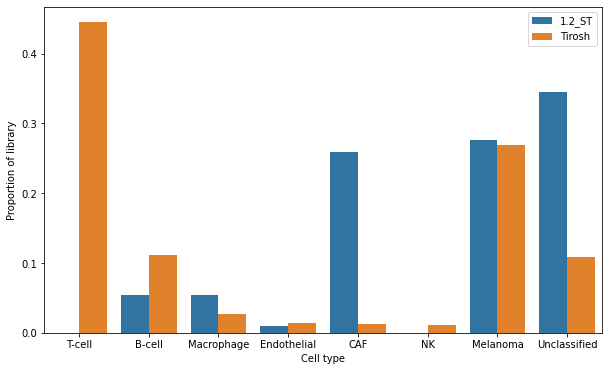

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(data=composition, y='fraction',
              x="cell_type_inferred", order=cell_types,
              hue="sampleID", hue_order=samples, ax=ax)
ax.set_xlabel("Cell type")
ax.set_ylabel("Proportion of library")
ax.legend(frameon=True)

## Cell type composition of each spatial cluster

In [ ]:
cluster_comp = ST.groupby(['spatial.cluster', 'cell_type_inferred']).size().reindex(index).fillna(0).astype(int)
cluster_comp = cluster_comp / cluster_comp.sum(level=0)
cluster_comp = cluster_comp.rename('fraction').reset_index()

cluster_comp = cluster_comp.pivot_table(index='spatial.cluster', columns='cell_type_inferred')
cluster_comp.columns = cluster_comp.columns.droplevel()
cluster_comp = cluster_comp.loc[range(1, 4), cell_types]

[Text(0, 0.5, 'T-cell'),
 Text(0, 1.5, 'B-cell'),
 Text(0, 2.5, 'Macrophage'),
 Text(0, 3.5, 'Endothelial'),
 Text(0, 4.5, 'CAF'),
 Text(0, 5.5, 'NK'),
 Text(0, 6.5, 'Melanoma'),
 Text(0, 7.5, 'Unclassified')]

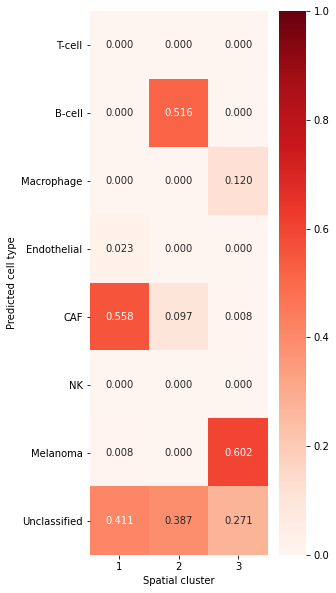

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
sns.heatmap(data=cluster_comp.T, 
            vmin=0, vmax=1, cmap='Reds',
            annot=True, fmt='.03f',
            ax=ax)

ax.set_xlabel("Spatial cluster")
ax.set_ylabel("Predicted cell type")
ax.set_yticklabels(cell_types, rotation=0, ha='right')

## Aligned UMAP projections

Get xlim and ylim for all other plots

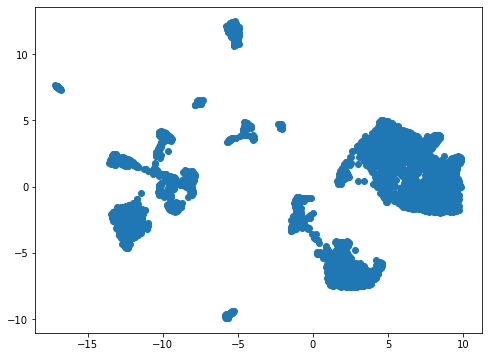

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
df = seurat.loc[seurat.sampleID == 'Tirosh']
ax.scatter(df.UMAP_1, df.UMAP_2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

## Prediction scores by cell type

In [228]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=0.25, pad=0.05)
    PCM = ax.get_children()[0]
    fig.colorbar(PCM, cax=cax, orientation='vertical')

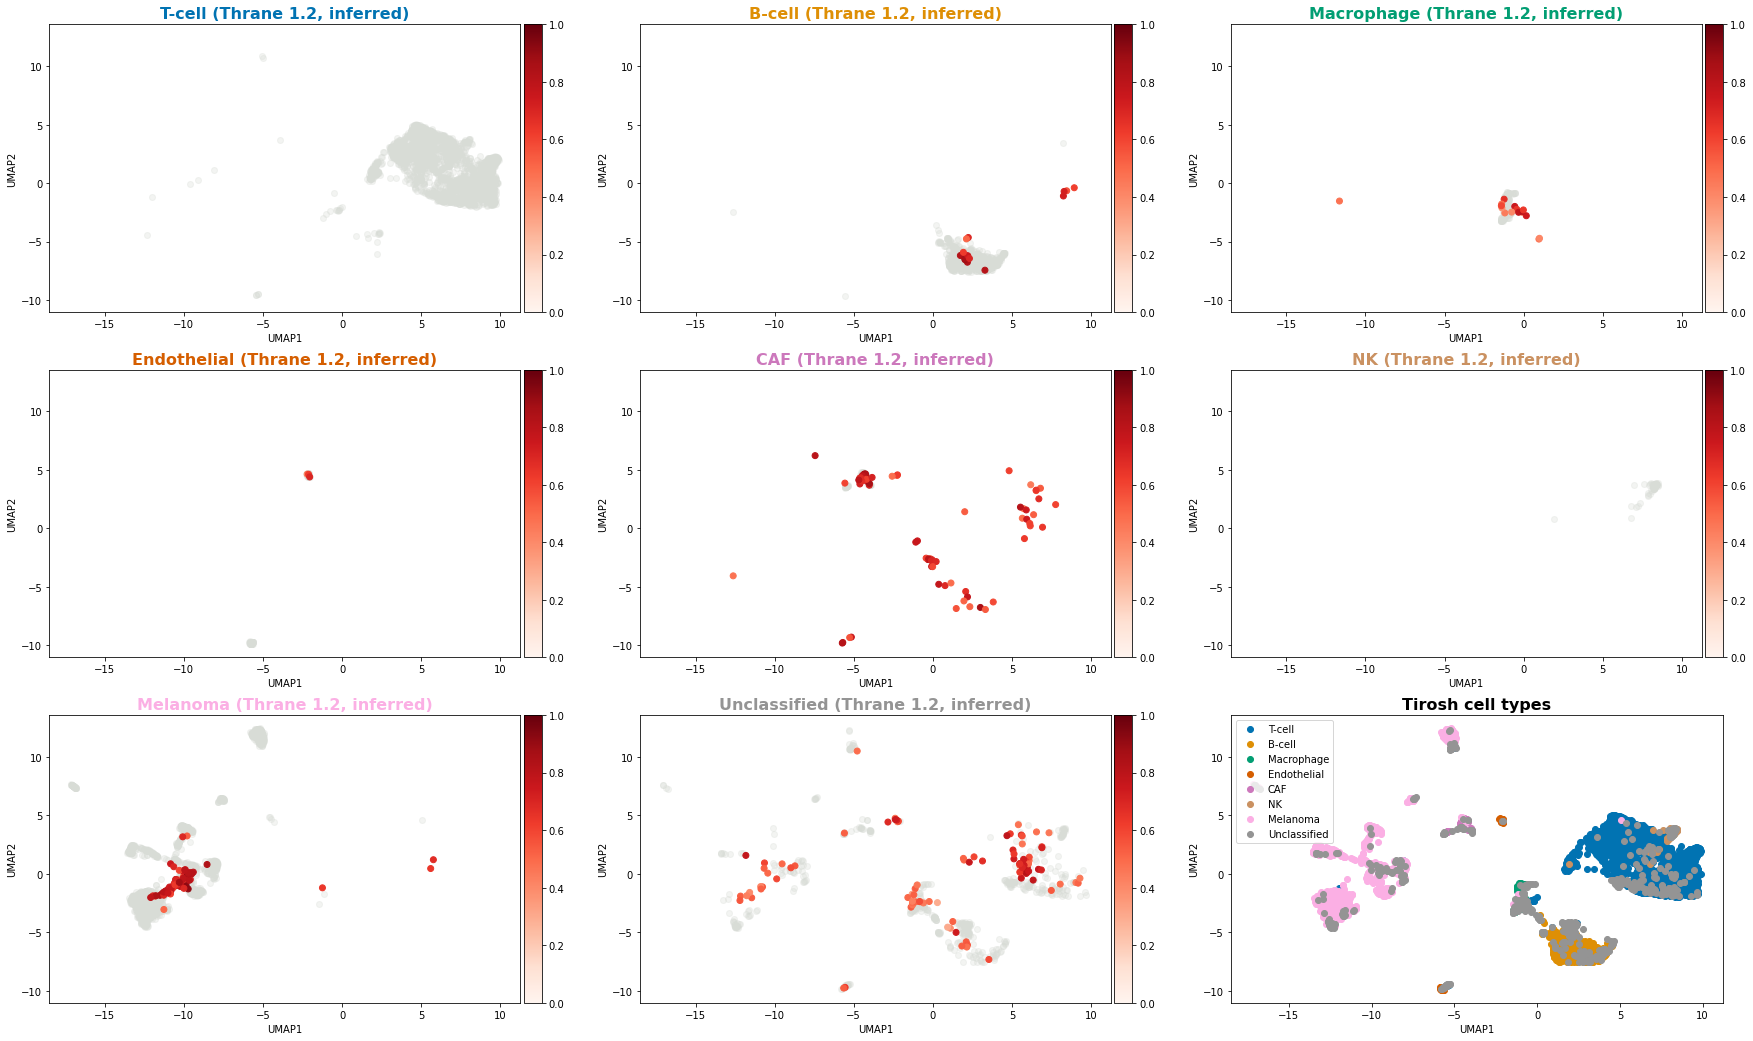

In [164]:
fig, axes = plt.subplots(3, 3, figsize=(30, 18))

for i, (cell_type, ax) in enumerate(zip(cell_types, axes.flat[:-1])):
    df = ST.loc[ST.cell_type_inferred == cell_type]
    
    ax.scatter(df.UMAP_1, df.UMAP_2,
               c=df['prediction.score.max'], cmap='Reds', vmin=0, vmax=1)
    add_colorbar(ax)
    
    df = seurat.loc[(seurat.sampleID == 'Tirosh') & (seurat.cell_type == cell_type)]
    ax.scatter(df.UMAP_1, df.UMAP_2, zorder=0, c=sns.xkcd_rgb['light grey'], alpha=0.3)
    
    ax.set_title(cell_type + " (Thrane 1.2, inferred)", 
                 color=palette[i], fontweight='bold', fontsize=16)

ax = axes.flat[-1]a
for cell_type in cell_types:
    df = seurat.loc[(seurat.sampleID == 'Tirosh') & (seurat.cell_type == cell_type)]
    ax.scatter(df.UMAP_1, df.UMAP_2, label=cell_type)
ax.set_title('Tirosh cell types', fontsize=16, fontweight='bold')
ax.legend(frameon=True)

for ax in axes.flat:
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

Boxplots of prediction scores by cell type

Text(0, 0.5, 'Seurat prediction score')

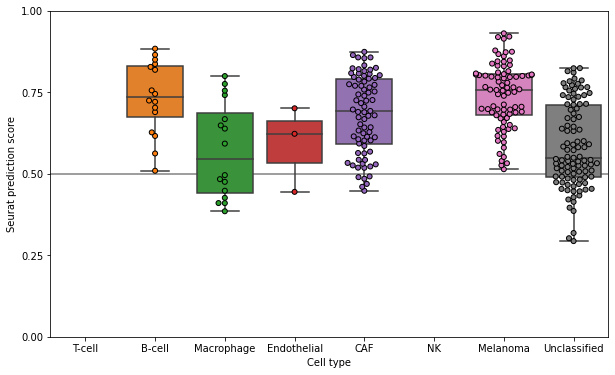

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax = sns.boxplot(data=ST, x="predicted.id", y="prediction.score.max", order=cell_types, ax=ax)
ax = sns.swarmplot(data=ST, x="predicted.id", y="prediction.score.max", order=cell_types, ax=ax, edgecolor='k', linewidth=1)
ax.axhline(0.5, c='gray', zorder=0)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel("Cell type")
ax.set_ylabel("Seurat prediction score")

# LIGER

## Load data

In [168]:
liger = pd.read_csv("results/alignment/LIGER_thrane1.2-tirosh_TSNE.csv", index_col=0)
liger.columns = ['TSNE1', 'TSNE2']

cols = 'cell_type tumor_status sampleID spatial.cluster'.split()
liger = liger.join(seurat[cols])

## Aligned T-SNE projection

Get xlim/ylim for other plots

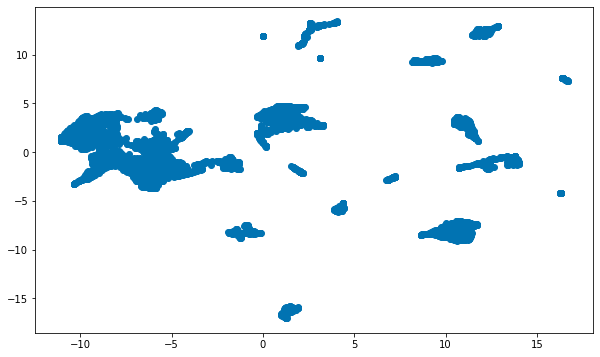

In [229]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(liger.TSNE1, liger.TSNE2)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

## Spatial clusters over cell types

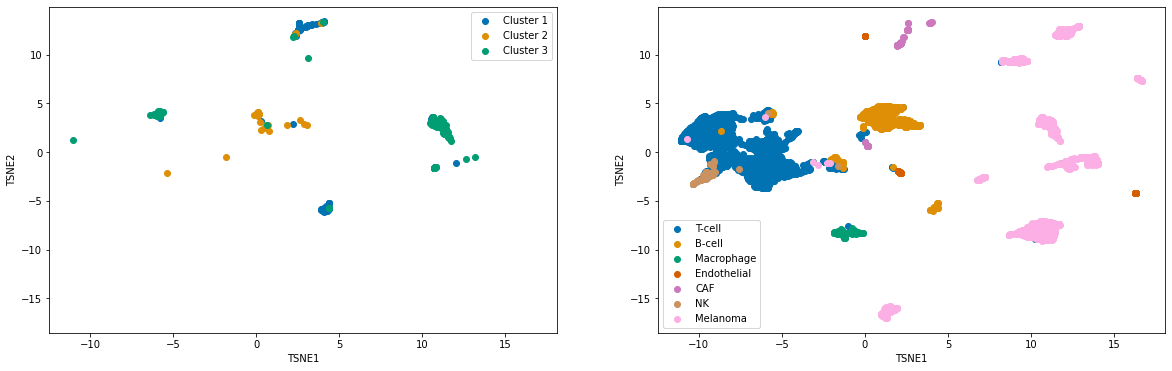

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax = axes[0]
sample = '1.2_ST'
for cluster in range(1, 4):
    df = liger.loc[(liger.sampleID == sample) & (liger['spatial.cluster'] == cluster)]
    ax.scatter(df.TSNE1, df.TSNE2, label=f'Cluster {cluster}')

ax = axes[1]
sample = 'Tirosh'
for cell_type in cell_types[:-1]:
    df = liger.loc[(liger.sampleID == sample) & (liger['cell_type'] == cell_type)]
    ax.scatter(df.TSNE1, df.TSNE2, label=cell_type)

for ax in axes:
    ax.legend(frameon=True)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel('TSNE1')
    ax.set_ylabel('TSNE2')